In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score, mean_absolute_percentage_error
import copy
import time


## Obróbka danych

In [5]:
# upload data
test_data = pd.read_excel('test.xlsx')
test_data.head(5)

,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory
0,The Complete Sherlock Holmes: 2 Boxes sets,Sir Arthur Conan Doyle,"Mass Market Paperback,– 1 Oct 1986",4.4 out of 5 stars,960 customer reviews,A collection of entire body of work of the She...,Short Stories (Books),"Crime, Thriller & Mystery"
1,Learn Docker - Fundamentals of Docker 18.x: Ev...,Gabriel N. Schenker,"Paperback,– Import, 26 Apr 2018",5.0 out of 5 stars,1 customer review,Enhance your software deployment workflow usin...,Operating Systems Textbooks,"Computing, Internet & Digital Media"
2,Big Girl,Danielle Steel,"Paperback,– 17 Mar 2011",5.0 out of 5 stars,4 customer reviews,"'Watch out, world. Here I come!'\nFor Victoria...",Romance (Books),Romance
3,Think Python: How to Think Like a Computer Sci...,Allen B. Downey,"Paperback,– 2016",4.1 out of 5 stars,11 customer reviews,"If you want to learn how to program, working w...",Programming & Software Development (Books),"Computing, Internet & Digital Media"
4,Oxford Word Skills: Advanced - Idioms & Phrasa...,Redman Gairns,"Paperback,– 26 Dec 2011",4.4 out of 5 stars,9 customer reviews,"Learn and practise the verbs, prepositions and...",Linguistics (Books),"Language, Linguistics & Writing"


In [6]:
train_data = pd.read_excel('train.xlsx')
train_data.head(5)

,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory,Price
0,The Prisoner's Gold (The Hunters 3),Chris Kuzneski,"Paperback,– 10 Mar 2016",4.0 out of 5 stars,8 customer reviews,THE HUNTERS return in their third brilliant no...,Action & Adventure (Books),Action & Adventure,220.00
1,Guru Dutt: A Tragedy in Three Acts,Arun Khopkar,"Paperback,– 7 Nov 2012",3.9 out of 5 stars,14 customer reviews,A layered portrait of a troubled genius for wh...,Cinema & Broadcast (Books),"Biographies, Diaries & True Accounts",202.93
2,Leviathan (Penguin Classics),Thomas Hobbes,"Paperback,– 25 Feb 1982",4.8 out of 5 stars,6 customer reviews,"""During the time men live without a common Pow...",International Relations,Humour,299.00
3,A Pocket Full of Rye (Miss Marple),Agatha Christie,"Paperback,– 5 Oct 2017",4.1 out of 5 stars,13 customer reviews,A handful of grain is found in the pocket of a...,Contemporary Fiction (Books),"Crime, Thriller & Mystery",180.00
4,LIFE 70 Years of Extraordinary Photography,Editors of Life,"Hardcover,– 10 Oct 2006",5.0 out of 5 stars,1 customer review,"For seven decades, ""Life"" has been thrilling t...",Photography Textbooks,"Arts, Film & Photography",965.62


In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6237 entries, 0 to 6236
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Title         6237 non-null   object 
 1   Author        6237 non-null   object 
 2   Edition       6237 non-null   object 
 3   Reviews       6237 non-null   object 
 4   Ratings       6237 non-null   object 
 5   Synopsis      6237 non-null   object 
 6   Genre         6237 non-null   object 
 7   BookCategory  6237 non-null   object 
 8   Price         6237 non-null   float64
dtypes: float64(1), object(8)
memory usage: 438.7+ KB


In [8]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Title         1560 non-null   object
 1   Author        1560 non-null   object
 2   Edition       1560 non-null   object
 3   Reviews       1560 non-null   object
 4   Ratings       1560 non-null   object
 5   Synopsis      1560 non-null   object
 6   Genre         1560 non-null   object
 7   BookCategory  1560 non-null   object
dtypes: object(8)
memory usage: 97.6+ KB


In [9]:
train_data.describe()

,Price
count,6237.000000
mean,560.707516
std,690.110657
min,25.000000
25%,249.180000
50%,373.000000
75%,599.000000
max,14100.000000


In [10]:
train_data.describe(include='all').head(2)

,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory,Price
count,6237,6237,6237,6237,6237,6237,6237,6237,6237.0
unique,5568,3679,3370,36,342,5549,345,11,NaN


In [11]:
train_data['Type'] = 'train'
test_data['Type'] = 'test'

data = pd.concat([train_data, test_data])
data.columns = data.columns.str.strip()

# usunięcie kolumny Synopsis
data = data.drop(['Synopsis', 'Title', 'Author'], axis=1)

# obróbka Reviews i Ratings na liczby
data['Reviews'] = data['Reviews'].apply(lambda x: x.split()[0]).astype('float')
data['Ratings'] = data['Ratings'].apply(lambda x: int(x.split()[0].replace(',', '')))

# rozkład Edition na skłądowe kolumny
data['Year'] = data['Edition'].apply(lambda x : x.split()[-1])
data['Year'] = data['Year'].apply(lambda x : x if x.isdigit() else np.nan)

data['Edition'] = data['Edition'].apply(lambda x : x.split(',')[1] if x.startswith('(') else x.split(',')[0])
data.head()

,Edition,Reviews,Ratings,Genre,BookCategory,Price,Type,Year
0,Paperback,4.0,8,Action & Adventure (Books),Action & Adventure,220.00,train,2016
1,Paperback,3.9,14,Cinema & Broadcast (Books),"Biographies, Diaries & True Accounts",202.93,train,2012
2,Paperback,4.8,6,International Relations,Humour,299.00,train,1982
3,Paperback,4.1,13,Contemporary Fiction (Books),"Crime, Thriller & Mystery",180.00,train,2017
4,Hardcover,5.0,1,Photography Textbooks,"Arts, Film & Photography",965.62,train,2006


In [12]:
data.Year.isna().sum()

30

In [13]:
# uzupełnienie brakujących danych
data['Year'] = data['Year'].fillna(data['Year'].mode().iloc[0]).astype(np.int16)
data.Year.isna().sum()

0

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7797 entries, 0 to 1559
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Edition       7797 non-null   object 
 1   Reviews       7797 non-null   float64
 2   Ratings       7797 non-null   int64  
 3   Genre         7797 non-null   object 
 4   BookCategory  7797 non-null   object 
 5   Price         6237 non-null   float64
 6   Type          7797 non-null   object 
 7   Year          7797 non-null   int16  
dtypes: float64(2), int16(1), int64(1), object(4)
memory usage: 502.5+ KB


In [15]:
data.describe()

,Reviews,Ratings,Price,Year
count,7797.000000,7797.000000,6237.000000,7797.000000
mean,4.295845,35.520841,560.707516,2011.916891
std,0.663513,153.020897,690.110657,7.831064
min,1.000000,1.000000,25.000000,1900.000000
25%,4.000000,2.000000,249.180000,2010.000000
50%,4.400000,6.000000,373.000000,2015.000000
75%,4.800000,21.000000,599.000000,2017.000000
max,5.000000,6090.000000,14100.000000,2019.000000


In [16]:
data.describe(include='all').head(2)

,Edition,Reviews,Ratings,Genre,BookCategory,Price,Type,Year
count,7797,7797.0,7797.0,7797,7797,6237.0,7797,7797.0
unique,15,NaN,NaN,363,11,NaN,2,NaN


In [17]:
data['Edition'].value_counts()

Paperback                6463
Hardcover                1056
Mass Market Paperback     200
Sheet music                32
Flexibound                 19
Cards                       9
Spiral-bound                6
Loose Leaf                  3
Tankobon Softcover          3
Plastic Comb                1
Perfect Paperback           1
Board book                  1
Product Bundle              1
Library Binding             1
Leather Bound               1
Name: Edition, dtype: int64

In [18]:
# kategoryzowanie
data['Edition'] = data['Edition'].apply(lambda x : x if x in ['Paperback','Hardcover','Mass Market Paperback','Sheet music','Flexibound'] else 'Others')
print(data['Edition'].value_counts())

# Year_bins = [0,1980,1990,2000,2010,2020,9999]
# data['Year'] = pd.cut(data['Year'], Year_bins, labels=['<1980','1990','2000','2010','2020','>2020'])
# print(data['Year'].value_counts())

Paperback                6463
Hardcover                1056
Mass Market Paperback     200
Sheet music                32
Others                     27
Flexibound                 19
Name: Edition, dtype: int64


In [19]:
data.head()

,Edition,Reviews,Ratings,Genre,BookCategory,Price,Type,Year
0,Paperback,4.0,8,Action & Adventure (Books),Action & Adventure,220.00,train,2016
1,Paperback,3.9,14,Cinema & Broadcast (Books),"Biographies, Diaries & True Accounts",202.93,train,2012
2,Paperback,4.8,6,International Relations,Humour,299.00,train,1982
3,Paperback,4.1,13,Contemporary Fiction (Books),"Crime, Thriller & Mystery",180.00,train,2017
4,Hardcover,5.0,1,Photography Textbooks,"Arts, Film & Photography",965.62,train,2006


C:\Users\Admin\AppData\Local\Temp/ipykernel_3228/4070461103.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), annot = True)


<AxesSubplot:>

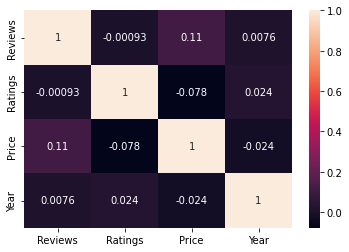

In [20]:
sns.heatmap(data.corr(), annot = True)
# plt.title("Wykres mapy ciepła zależności wart. liczbowych w zbiorze\n")

In [21]:
data['Genre'].value_counts()

Action & Adventure (Books)               1183
Romance (Books)                           517
Biographies & Autobiographies (Books)     463
Crime, Thriller & Mystery (Books)         335
Contemporary Fiction (Books)              325
                                         ... 
Bodybuilding & Weightlifting (Books)        1
Immunology                                  1
Target Shooting (Books)                     1
Ecotourism                                  1
Military History (Books)                    1
Name: Genre, Length: 363, dtype: int64

In [22]:
data['BookCategory'].value_counts()

Action & Adventure                      1036
Crime, Thriller & Mystery                878
Comics & Mangas                          744
Language, Linguistics & Writing          733
Biographies, Diaries & True Accounts     732
Romance                                  702
Humour                                   670
Computing, Internet & Digital Media      648
Arts, Film & Photography                 638
Sports                                   614
Politics                                 402
Name: BookCategory, dtype: int64

In [23]:
data = data.drop(["Genre"], axis=1)
data.head()

,Edition,Reviews,Ratings,BookCategory,Price,Type,Year
0,Paperback,4.0,8,Action & Adventure,220.00,train,2016
1,Paperback,3.9,14,"Biographies, Diaries & True Accounts",202.93,train,2012
2,Paperback,4.8,6,Humour,299.00,train,1982
3,Paperback,4.1,13,"Crime, Thriller & Mystery",180.00,train,2017
4,Hardcover,5.0,1,"Arts, Film & Photography",965.62,train,2006


In [24]:
# podział na zbiory testowy i treningowy
train = data[data["Type"] == 'train']
test = data[data["Type"] == 'test']

train = train.drop(['Type'], axis=1)
test = test.drop(['Type'], axis=1)

train.head()

,Edition,Reviews,Ratings,BookCategory,Price,Year
0,Paperback,4.0,8,Action & Adventure,220.00,2016
1,Paperback,3.9,14,"Biographies, Diaries & True Accounts",202.93,2012
2,Paperback,4.8,6,Humour,299.00,1982
3,Paperback,4.1,13,"Crime, Thriller & Mystery",180.00,2017
4,Hardcover,5.0,1,"Arts, Film & Photography",965.62,2006


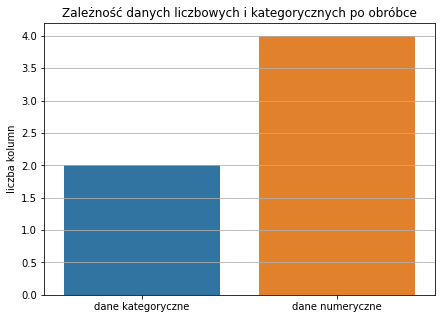

In [25]:
col_data_type = []
for col in train.columns:
    if pd.api.types.is_numeric_dtype(train[col]):
        col_data_type.append('dane numeryczne')
    else:
        col_data_type.append('dane kategoryczne')


plt.figure(figsize=(7,5))
plt.grid()
sns.countplot(x=col_data_type)
plt.ylabel('liczba kolumn')
plt.title('Zależność danych liczbowych i kategorycznych po obróbce')
plt.show()

## Kodowanie i skalowanie danych

In [26]:
encode = LabelEncoder()
new_data = copy.copy(data)
new_data['Edition'] = encode.fit_transform(list(data['Edition']))
new_data['BookCategory'] = encode.fit_transform(list(data['BookCategory']))
new_data['Year'] = encode.fit_transform(list(data['Year']))
new_data.head()

,Edition,Reviews,Ratings,BookCategory,Price,Type,Year
0,4,4.0,8,0,220.00,train,54
1,4,3.9,14,2,202.93,train,50
2,4,4.8,6,6,299.00,train,20
3,4,4.1,13,5,180.00,train,55
4,1,5.0,1,1,965.62,train,44


In [27]:
# podział na zbiory testowy i treningowy
new_train = new_data[new_data["Type"] == 'train']
new_test = new_data[new_data["Type"] == 'test']

new_train = new_train.drop(['Type'], axis=1)
new_test = new_test.drop(['Type'], axis=1)

# train.to_excel("train_proccessed.xlsx")
# test.to_excel("train_proccessed.xlsx")
new_train.head()

,Edition,Reviews,Ratings,BookCategory,Price,Year
0,4,4.0,8,0,220.00,54
1,4,3.9,14,2,202.93,50
2,4,4.8,6,6,299.00,20
3,4,4.1,13,5,180.00,55
4,1,5.0,1,1,965.62,44


In [28]:
X_train = new_train.drop(['Price'],axis = 1)
y_train = new_train['Price'].values
X_test = new_test.drop(["Price"], axis=1)
# X_train.describe(include = 'all')

# np.savetxt("X_train.csv", X_train)
# np.savetxt("X_test.csv", X_test)
# np.savetxt("y_train.csv", y_train)

# # SCALE
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

# reshaping
y_train = y_train.reshape((len(y_train), 1))
y_train = sc.fit_transform(y_train)
y_train = y_train.ravel()

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(X_train)

(6237, 5)
(1560, 5)
(6237,)
[[ 0.42881945 -0.44260333 -0.18658305 -1.46017334  0.53345711]
 [ 0.42881945 -0.59355848 -0.14657852 -0.82907247  0.00957552]
 [ 0.42881945  0.76503793 -0.1999179   0.43312927 -3.91953646]
 ...
 [ 0.42881945 -0.74451364 -0.21992016  1.37978058 -0.77624688]
 [ 0.42881945 -1.19737911 -0.21325274 -1.46017334  0.40248671]
 [ 0.42881945 -0.59355848 -0.22658759 -1.46017334  0.53345711]]


In [29]:
# np.savetxt("X_train.csv", X_train)
# np.savetxt("X_test.csv", X_test)
# np.savetxt("y_train.csv", y_train)

## XGBoost

In [30]:
train_x, val_x, train_y, val_y = train_test_split(X_train, y_train, test_size = 0.33, random_state = 123)

# make plot with different test sizes to show which is more optimal

print(train_x.shape)
print(train_y.shape)
print(val_x.shape)
print(val_y.shape)

(4178, 5)
(4178,)
(2059, 5)
(2059,)


Training score 0.8963776302828373
Mean absolute percentage error 0.985649565036682


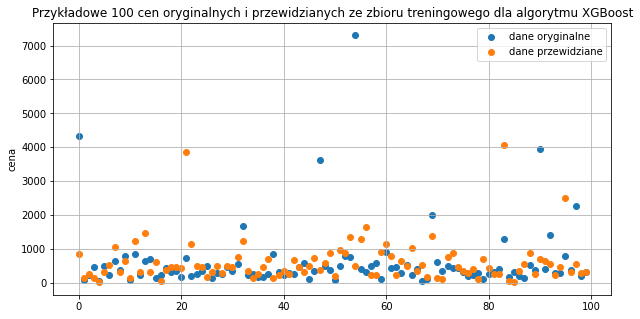

In [31]:
xgb=XGBRegressor(n_estimators=2000, max_depth=7, learning_rate = 0.1)

xgb.fit(train_x, train_y)

y_ = xgb.predict(val_x)

y_pred = sc.inverse_transform([y_])
y_true = sc.inverse_transform([val_y])

score_ = xgb.score(train_x, train_y)
score_perc = mean_absolute_percentage_error(y_pred, y_true)
print("Training score", score_)
print("Mean absolute percentage error", score_perc)

x_ax = range(len(y_true[0][:100]))

plt.figure(figsize=(10,5))
plt.scatter(x_ax, y_true[0][:100], label="dane oryginalne")
plt.scatter(x_ax, y_pred[0][:100], label="dane przewidziane")
plt.title("Przykładowe 100 cen oryginalnych i przewidzianych ze zbioru treningowego dla algorytmu XGBoost")
plt.ylabel('cena')
plt.grid()
plt.legend()
plt.show()

In [32]:
def xgb_estimators(X_train, y_train, X_test, n):
    xgb=XGBRegressor(n_estimators=n, max_depth=6, learning_rate = 0.1)

    xgb.fit(X_train, y_train)

    y_ = xgb.predict(X_test)

    return xgb.score(X_train, y_train)
    # score = mean_squared_error(y_true, y_pred)
    # error = 1 - np.sqrt(np.square(np.log10(y_pred + 1) - np.log10(y_true + 1)).mean())
    # rsme = np.sqrt(mean_squared_error(y_pred, y_true))

Training score:  0.5039427526567345
Training score:  0.628494562168564
Training score:  0.6901216418043856
Training score:  0.7231995973339544
Training score:  0.7491667685878274
Training score:  0.7692289303170099
Training score:  0.7840635605028036
Training score:  0.7951775246339129
Training score:  0.8034068688392966
Training score:  0.8106279748756485
Training score:  0.8156406832184091
Training score:  0.8210125026560494


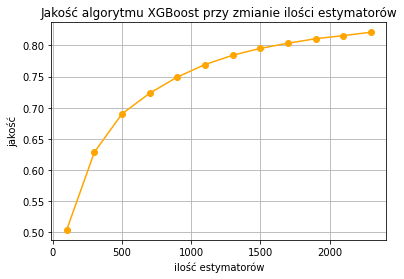

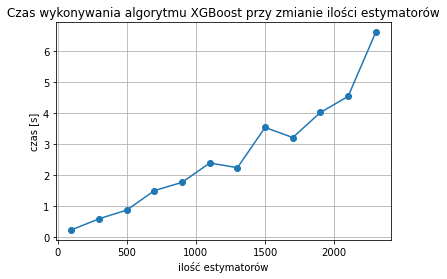

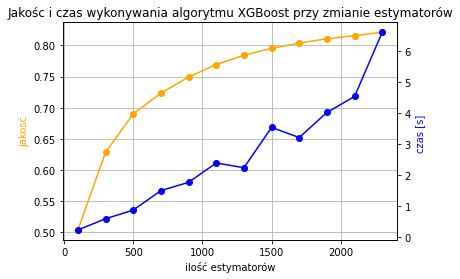

In [33]:
skorr = []
times = []
N = np.arange(100, 2500, 200)
for n in N:
    start = time.time()
    score_ = xgb_estimators(X_train=X_train, y_train=y_train, X_test=X_test,  n=n)
    stop = time.time()

    print("Training score: ", score_)
    skorr.append(score_)
    times.append(stop-start)

plt.figure()
plt.plot(N, skorr, '-o', color='orange')
plt.title('Jakość algorytmu XGBoost przy zmianie ilości estymatorów')
plt.grid()
plt.ylabel('jakość')
plt.xlabel('ilość estymatorów')
plt.show()

plt.figure()
plt.plot(N, times, '-o')
plt.title('Czas wykonywania algorytmu XGBoost przy zmianie ilości estymatorów')
plt.grid()
plt.ylabel('czas [s]')
plt.xlabel('ilość estymatorów')
plt.show()

fig, ax1 = plt.subplots()
ax1.plot(N, skorr, color='orange', marker='o')
ax1.grid()
ax1.set_title('Jakośc i czas wykonywania algorytmu XGBoost przy zmianie estymatorów')
ax1.set_xlabel('ilość estymatorów')
ax1.set_ylabel('jakosć', color='orange')

ax2=ax1.twinx()
ax2.plot(N, times, color='blue', marker='o')
ax2.set_ylabel("czas [s] ", color='blue')
plt.show()

In [34]:
def xgb_depth(X_train, y_train, X_test, d):

    xgb=XGBRegressor(n_estimators=2100, max_depth=d, learning_rate = 0.1)

    xgb.fit(X_train, y_train)

    y_ = xgb.predict(X_test)

    return xgb.score(X_train, y_train)

Training score:  0.185421452245637
Training score:  0.2876261231310321
Training score:  0.46221208328806607
Training score:  0.611414001786333
Training score:  0.7359415232285741
Training score:  0.8156406832184091
Training score:  0.8477357776324338
Training score:  0.8534618009858026
Training score:  0.8536844813664793
Training score:  0.8537322510001268
Training score:  0.853788958808836
Training score:  0.8537818290744411
Training score:  0.8538374841038239
Training score:  0.8538428038590009


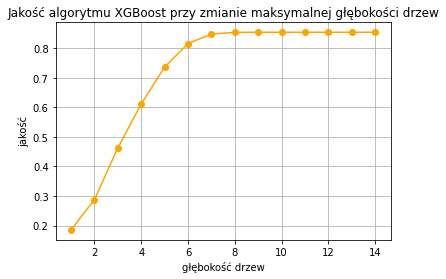

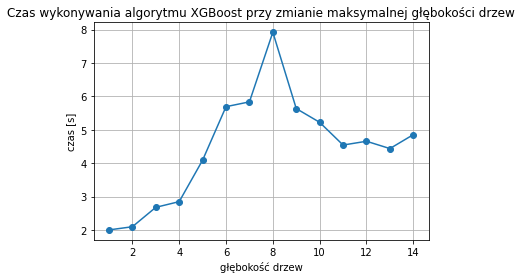

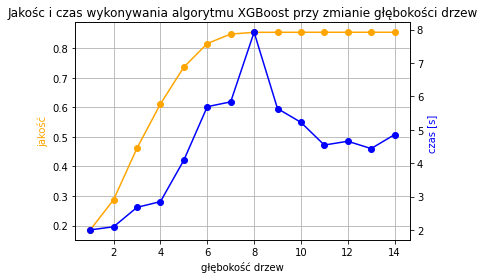

In [35]:
skorr = []
times = []

D = np.arange(1, 15)
for d in D:
    start = time.time()
    score_ = xgb_depth(X_train=X_train, y_train=y_train, X_test=X_test, d=d)
    stop = time.time()

    print("Training score: ", score_)
    skorr.append(score_)
    times.append(stop-start)

plt.figure()
plt.plot(D, skorr, '-o', color='orange')
plt.title('Jakość algorytmu XGBoost przy zmianie maksymalnej głębokości drzew')
plt.grid()
plt.ylabel('jakość')
plt.xlabel('głębokość drzew')
plt.show()

plt.figure()
plt.plot(D, times, '-o')
plt.title('Czas wykonywania algorytmu XGBoost przy zmianie maksymalnej głębokości drzew')
plt.grid()
plt.ylabel('czas [s]')
plt.xlabel('głębokość drzew')
plt.show()

fig, ax1 = plt.subplots()
ax1.plot(D, skorr, color='orange', marker='o')
ax1.grid()
ax1.set_title('Jakośc i czas wykonywania algorytmu XGBoost przy zmianie głębokości drzew')
ax1.set_xlabel('głębokość drzew')
ax1.set_ylabel('jakość', color='orange')

ax2=ax1.twinx()
ax2.plot(D, times, color='blue', marker='o')
ax2.set_ylabel("czas [s] ", color='blue')
plt.show()

In [36]:
def xgb_learn(X_train, y_train, X_test, i):

    xgb=XGBRegressor(n_estimators=2100, max_depth=8, learning_rate = i)

    xgb.fit(X_train, y_train)

    y_ = xgb.predict(X_test)

    return xgb.score(X_train, y_train)

Training score:  0.8534618009858026
Training score:  0.8536894427854244
Training score:  0.853754884940201
Training score:  0.8538047823941899
Training score:  0.8538241091945435
Training score:  0.8538383808139985
Training score:  0.8538506912301173
Training score:  0.8538530804776934
Training score:  0.8538559760390811
Training score:  0.8538666176732177


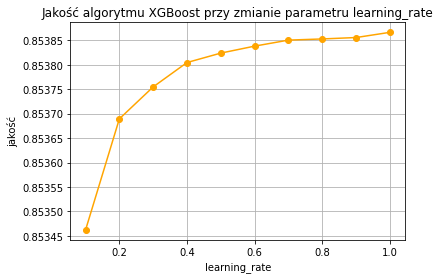

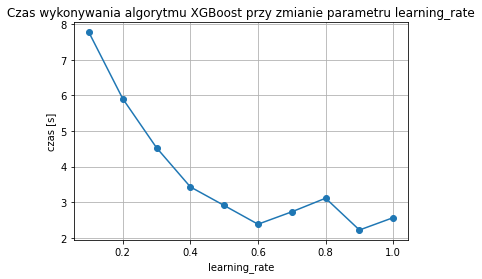

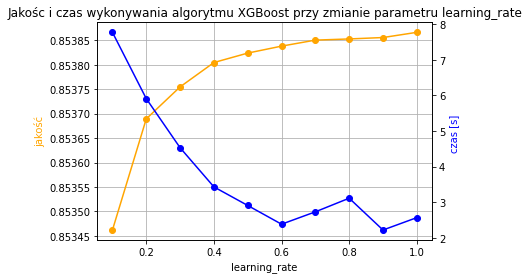

In [37]:
skorr = []
times = []

I = np.arange(0.1, 1.1, 0.1)
for i in I:
    start = time.time()
    score_ = xgb_learn(X_train=X_train, y_train=y_train, X_test=X_test, i=i)
    stop = time.time()

    print("Training score: ", score_)
    skorr.append(score_)
    times.append(stop-start)

plt.figure()
plt.plot(I, skorr, '-o', color='orange')
plt.title('Jakość algorytmu XGBoost przy zmianie parametru learning_rate')
plt.grid()
plt.ylabel('jakość')
plt.xlabel('learning_rate')
plt.show()

plt.figure()
plt.plot(I, times, '-o')
plt.title('Czas wykonywania algorytmu XGBoost przy zmianie parametru learning_rate')
plt.grid()
plt.ylabel('czas [s]')
plt.xlabel('learning_rate')
plt.show()

fig, ax1 = plt.subplots()
ax1.plot(I, skorr, color='orange', marker='o')
ax1.grid()
ax1.set_title('Jakośc i czas wykonywania algorytmu XGBoost przy zmianie parametru learning_rate')
ax1.set_xlabel('learning_rate')
ax1.set_ylabel('jakość', color='orange')

ax2=ax1.twinx()
ax2.plot(I, times, color='blue', marker='o')
ax2.set_ylabel("czas [s] ", color='blue')
plt.show()

In [38]:
start = time.time()
xgb=XGBRegressor(n_estimators=2100, max_depth=7, learning_rate = 0.3)

xgb.fit(X_train, y_train)

y_ = xgb.predict(X_test)
stop = time.time()

y_pred = sc.inverse_transform([y_])

score_ = xgb.score(X_train, y_train)  
print("Training score: ", score_)
print("Time:", stop-start)

solution = pd.DataFrame(y_pred[0], columns = ['Price'])
solution.to_excel('XGB_output.xlsx')

Training score:  0.8536017903866019
Time: 3.856149673461914


In [39]:
solution.describe()

,Price
count,1560.000000
mean,522.048050
std,466.724744
min,-358.971432
25%,269.534528
50%,408.385707
75%,648.396309
max,5635.230687


## HistGradientBoost

Training score 0.7560265534711059
Mean absolute percentage error 1.2855922808832487


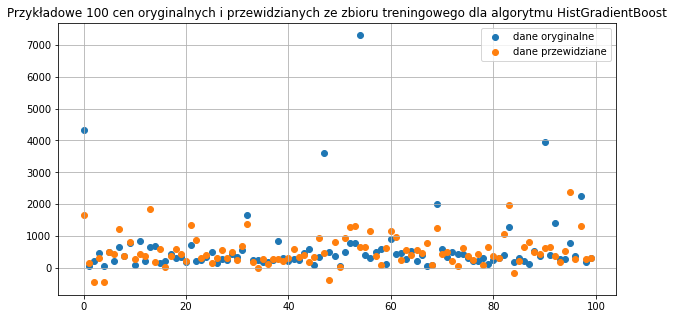

In [40]:
train_x, val_x, train_y, val_y = train_test_split(X_train, y_train, test_size = 0.33, random_state = 123)

hist = HistGradientBoostingRegressor(max_iter=1500, max_leaf_nodes=31, max_depth=7)

hist.fit(train_x, train_y)

y_ = hist.predict(val_x)

y_pred = sc.inverse_transform([y_])
y_true = sc.inverse_transform([val_y])

score_ = hist.score(train_x, train_y)  
score_perc = mean_absolute_percentage_error(y_pred, y_true)
print("Training score", score_)
print("Mean absolute percentage error", score_perc)

x_ax = range(len(y_true[0][:100]))

plt.figure(figsize=(10,5))
plt.scatter(x_ax, y_true[0][:100], label="dane oryginalne")
plt.scatter(x_ax, y_pred[0][:100], label="dane przewidziane")
plt.title("Przykładowe 100 cen oryginalnych i przewidzianych ze zbioru treningowego dla algorytmu HistGradientBoost")
plt.grid()
plt.legend()
plt.show()

In [41]:
def hist_loss(X_train, y_train, X_test, i):
    hist = HistGradientBoostingRegressor(loss=i, quantile=0.9, learning_rate=0.1, max_iter=1500, max_leaf_nodes=31, max_depth=7)

    hist.fit(X_train, y_train)

    y_ = hist.predict(X_test)

    return hist.score(X_train, y_train)

Training score:  0.6588656271687501
Training score:  0.19850608946163173
Training score:  -0.11825842954917487


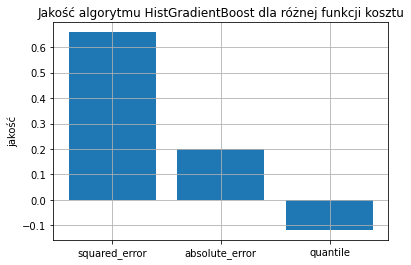

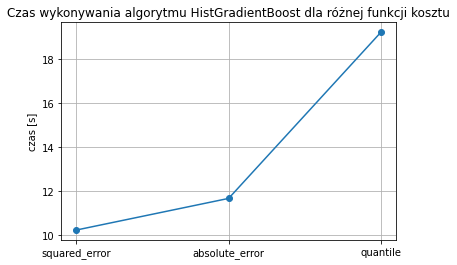

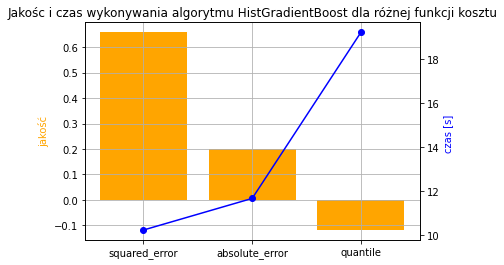

In [42]:
losses = ['squared_error', 'absolute_error', 'quantile']
loss_score = []
times = []
for i in losses:
    start = time.time()
    score_ = hist_loss(X_train=X_train, y_train=y_train, X_test=X_test, i=i)
    stop = time.time()

    print("Training score: ", score_)
    loss_score.append(score_)
    times.append(stop-start)

plt.figure()
plt.bar(losses, loss_score)
plt.title('Jakość algorytmu HistGradientBoost dla różnej funkcji kosztu')
plt.grid()
plt.ylabel('jakość')
# plt.xlabel('ilość estymatorów')
plt.show()

plt.figure()
plt.plot(losses, times, '-o')
plt.title('Czas wykonywania algorytmu HistGradientBoost dla różnej funkcji kosztu')
plt.grid()
plt.ylabel('czas [s]')
# plt.xlabel(losses)
plt.show()

fig, ax1 = plt.subplots()
ax1.bar(losses, loss_score, color='orange')
ax1.grid()
ax1.set_title('Jakośc i czas wykonywania algorytmu HistGradientBoost dla różnej funkcji kosztu')
# ax1.set_xlabel('głębokość drzew')
ax1.set_ylabel('jakość', color='orange')

ax2=ax1.twinx()
ax2.plot(losses, times, color='blue', marker='o')
ax2.set_ylabel("czas [s] ", color='blue')
plt.show()


In [43]:
def hist_iter(X_train, y_train, X_test, n):
    hist = HistGradientBoostingRegressor(max_iter=n, max_leaf_nodes=31, max_depth=7)

    hist.fit(X_train, y_train)

    y_ = hist.predict(X_test)

    return hist.score(X_train, y_train)

Training score:  0.35418988190551615
Training score:  0.4518482400552908
Training score:  0.5208108940412689
Training score:  0.56467927492471
Training score:  0.5975872341145432
Training score:  0.62485981572284
Training score:  0.6451147563822645
Training score:  0.6588656271687501
Training score:  0.6744589877781553
Training score:  0.6897499551470853
Training score:  0.6985339927113356
Training score:  0.7074053385327033
Training score:  0.714602934386659
Training score:  0.7222249422006586
Training score:  0.7292789074665663
Training score:  0.7354166053354441
Training score:  0.7432084236424215


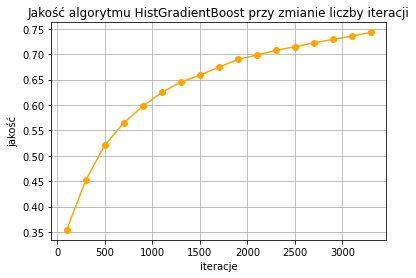

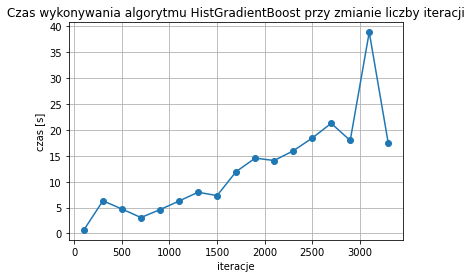

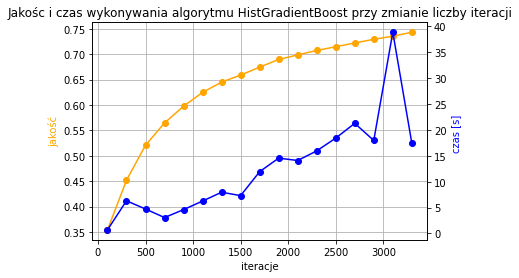

In [44]:
N = np.arange(100, 3500, 200)
iter_score = []
times = []
for n in N:
    start = time.time()
    score_ = hist_iter(X_train=X_train, y_train=y_train, X_test=X_test, n=n)
    stop = time.time()

    print("Training score: ", score_)
    iter_score.append(score_)
    times.append(stop-start)

plt.figure()
plt.plot(N, iter_score, '-o', color='orange')
plt.title('Jakość algorytmu HistGradientBoost przy zmianie liczby iteracji')
plt.grid()
plt.ylabel('jakość')
plt.xlabel('iteracje')
plt.show()

plt.figure()
plt.plot(N, times, '-o')
plt.title('Czas wykonywania algorytmu HistGradientBoost przy zmianie liczby iteracji')
plt.grid()
plt.ylabel('czas [s]')
plt.xlabel('iteracje')
plt.show()

fig, ax1 = plt.subplots()
ax1.plot(N, iter_score, color='orange', marker='o')
ax1.grid()
ax1.set_title('Jakośc i czas wykonywania algorytmu HistGradientBoost przy zmianie liczby iteracji')
ax1.set_xlabel('iteracje')
ax1.set_ylabel('jakość', color='orange')

ax2=ax1.twinx()
ax2.plot(N, times, color='blue', marker='o')
ax2.set_ylabel("czas [s] ", color='blue')
plt.show()

In [45]:
def hist_leaf(X_train, y_train, X_test, i):
    hist = HistGradientBoostingRegressor(max_iter=2000, max_leaf_nodes=i, max_depth=7)
    hist.fit(X_train, y_train)

    Y_pred = hist.predict(X_test)

    return hist.score(X_train, y_train)  

Training score:  0.17816785332611662
Training score:  0.3422629543724317
Training score:  0.45577262183187806
Training score:  0.5263389149230429
Training score:  0.5546276784868935
Training score:  0.5926191783257775
Training score:  0.6121808790319894
Training score:  0.6230723983686814
Training score:  0.6419306532028786
Training score:  0.6531794087591617
Training score:  0.6595859212907409
Training score:  0.6679026169452742
Training score:  0.67945865336858
Training score:  0.6858899731262263
Training score:  0.6898394838709375


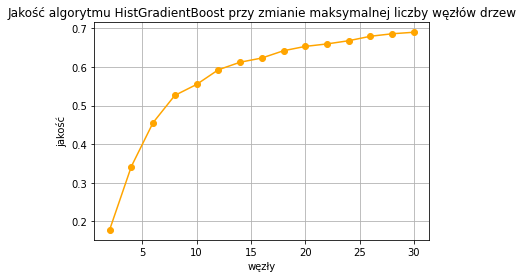

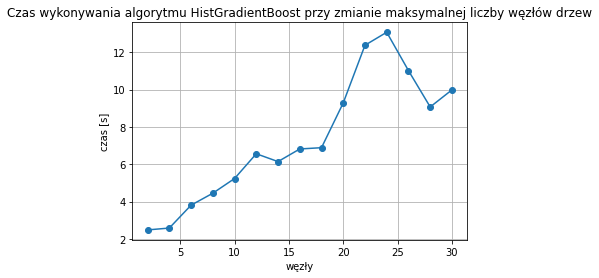

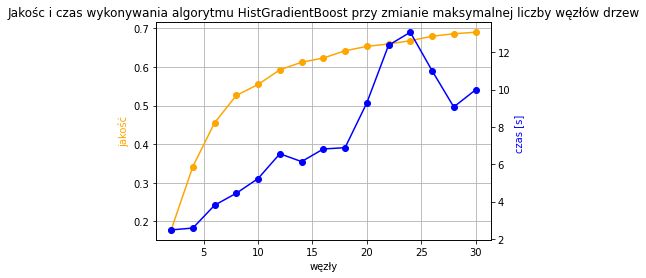

In [46]:
N = np.arange(2, 31, 2)
leaf_score = []
times = []
for i in N:
    start = time.time()
    score_ = hist_leaf(X_train=X_train, y_train=y_train, X_test=X_test, i=i)
    stop = time.time()

    print("Training score: ", score_)
    leaf_score.append(score_)
    times.append(stop-start)

plt.figure()
plt.plot(N, leaf_score, '-o', color='orange')
plt.title('Jakość algorytmu HistGradientBoost przy zmianie maksymalnej liczby węzłów drzew')
plt.grid()
plt.ylabel('jakość')
plt.xlabel('węzły')
plt.show()

plt.figure()
plt.plot(N, times, '-o')
plt.title('Czas wykonywania algorytmu HistGradientBoost przy zmianie maksymalnej liczby węzłów drzew')
plt.grid()
plt.ylabel('czas [s]')
plt.xlabel('węzły')
plt.show()

fig, ax1 = plt.subplots()
ax1.plot(N, leaf_score, color='orange', marker='o')
ax1.grid()
ax1.set_title('Jakośc i czas wykonywania algorytmu HistGradientBoost przy zmianie maksymalnej liczby węzłów drzew')
ax1.set_xlabel('węzły')
ax1.set_ylabel('jakość', color='orange')

ax2=ax1.twinx()
ax2.plot(N, times, color='blue', marker='o')
ax2.set_ylabel("czas [s] ", color='blue')
plt.show()

In [47]:
def hist_depth(X_train, y_train, X_test, n):
    hist = HistGradientBoostingRegressor(max_iter=2000, max_leaf_nodes=20, max_depth=n)
    hist.fit(X_train, y_train)

    Y_pred = hist.predict(X_test)

    return hist.score(X_train, y_train) 

Training score:  0.17816785332611662
Training score:  0.26081688925652124
Training score:  0.38433638156030236
Training score:  0.4953522022000899
Training score:  0.5823898168228283
Training score:  0.6259511078644537
Training score:  0.6531794087591617
Training score:  0.6650827256853715
Training score:  0.6717444896381137
Training score:  0.6815284378982939
Training score:  0.6805044797668701
Training score:  0.6864513529604839
Training score:  0.6816605633670427
Training score:  0.6816270667286202


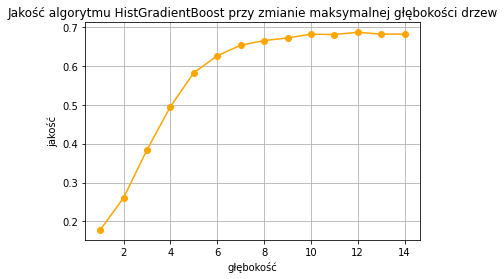

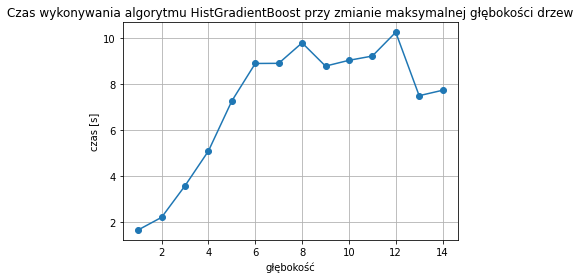

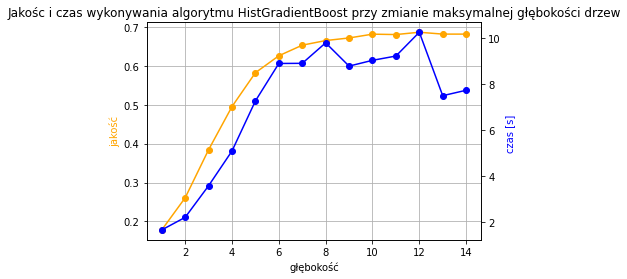

In [48]:
N = np.arange(1, 15, 1)
depth_score = []
times = []
for n in N:
    start = time.time()
    score_ = hist_depth(X_train=X_train, y_train=y_train, X_test=X_test, n=n)
    stop = time.time()

    print("Training score: ", score_)
    depth_score.append(score_)
    times.append(stop-start)

plt.figure()
plt.plot(N, depth_score, '-o', color='orange')
plt.title('Jakość algorytmu HistGradientBoost przy zmianie maksymalnej głębokości drzew')
plt.grid()
plt.ylabel('jakość')
plt.xlabel('głębokość')
plt.show()

plt.figure()
plt.plot(N, times, '-o')
plt.title('Czas wykonywania algorytmu HistGradientBoost przy zmianie maksymalnej głębokości drzew')
plt.grid()
plt.ylabel('czas [s]')
plt.xlabel('głębokość')
plt.show()

fig, ax1 = plt.subplots()
ax1.plot(N, depth_score, color='orange', marker='o')
ax1.grid()
ax1.set_title('Jakośc i czas wykonywania algorytmu HistGradientBoost przy zmianie maksymalnej głębokości drzew')
ax1.set_xlabel('głębokość')
ax1.set_ylabel('jakość', color='orange')

ax2=ax1.twinx()
ax2.plot(N, times, color='blue', marker='o')
ax2.set_ylabel("czas [s] ", color='blue')
plt.show()

In [49]:
def hist_learn(X_train, y_train, X_test, n):
    hist = HistGradientBoostingRegressor(max_iter=2000, max_leaf_nodes=20, max_depth=8, learning_rate=n)
    hist.fit(X_train, y_train)

    Y_pred = hist.predict(X_test)

    return hist.score(X_train, y_train) 

Training score:  0.6650827256853715
Training score:  0.7432893051615711
Training score:  0.7843071317182011
Training score:  0.8044403943197919
Training score:  0.8190945049138824
Training score:  0.8273299304730339
Training score:  0.8329071615406481
Training score:  0.8372885363901005
Training score:  0.8407296328285501
Training score:  0.8432850275814843


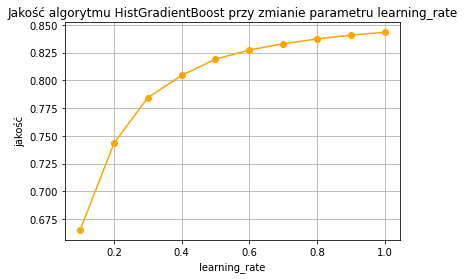

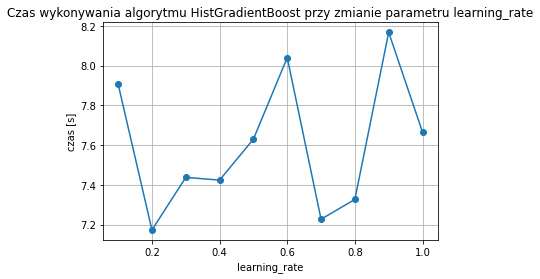

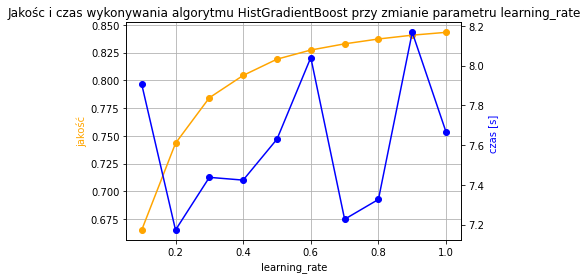

In [50]:
N = np.arange(0.1, 1.1, 0.1)
learn_score = []
times = []
for n in N:
    start = time.time()
    score_ = hist_learn(X_train=X_train, y_train=y_train, X_test=X_test, n=n)
    stop = time.time()

    print("Training score: ", score_)
    learn_score.append(score_)
    times.append(stop-start)

plt.figure()
plt.plot(N, learn_score, '-o', color='orange')
plt.title('Jakość algorytmu HistGradientBoost przy zmianie parametru learning_rate')
plt.grid()
plt.ylabel('jakość')
plt.xlabel('learning_rate')
plt.show()

plt.figure()
plt.plot(N, times, '-o')
plt.title('Czas wykonywania algorytmu HistGradientBoost przy zmianie parametru learning_rate')
plt.grid()
plt.ylabel('czas [s]')
plt.xlabel('learning_rate')
plt.show()

fig, ax1 = plt.subplots()
ax1.plot(N, learn_score, color='orange', marker='o')
ax1.grid()
ax1.set_title('Jakośc i czas wykonywania algorytmu HistGradientBoost przy zmianie parametru learning_rate')
ax1.set_xlabel('learning_rate')
ax1.set_ylabel('jakość', color='orange')

ax2=ax1.twinx()
ax2.plot(N, times, color='blue', marker='o')
ax2.set_ylabel("czas [s] ", color='blue')
plt.show()

In [51]:
def predict_final(X_train, y_train, X_test, m, n, i, d):
    
    start = time.time()
    hist = HistGradientBoostingRegressor(learning_rate=m, max_iter=n, max_leaf_nodes=i, max_depth=d)

    hist.fit(X_train, y_train)

    y_ = hist.predict(X_test)
    stop = time.time()

    y_pred = sc.inverse_transform([y_])
   
    score_ = hist.score(X_train, y_train)  
    print("Training score: ", score_)
    print("Time:", stop-start)

    # return score_
    solution = pd.DataFrame(y_pred[0], columns = ['Price'])
    solution.to_excel('HistGradBoost_output.xlsx')
    return score_, solution

In [52]:
s, sol = predict_final(X_train, y_train, X_test, 0.6, 2000, 20, 8)

Training score:  0.8273299304730339
Time: 7.381554365158081


In [53]:
sol.describe()

,Price
count,1560.000000
mean,501.228315
std,537.025964
min,-1224.893128
25%,196.357448
50%,409.947269
75%,686.926575
max,4837.978053


## RandomForest

Training score 0.7858265048346545
Mean absolute percentage error 0.5569078085926056


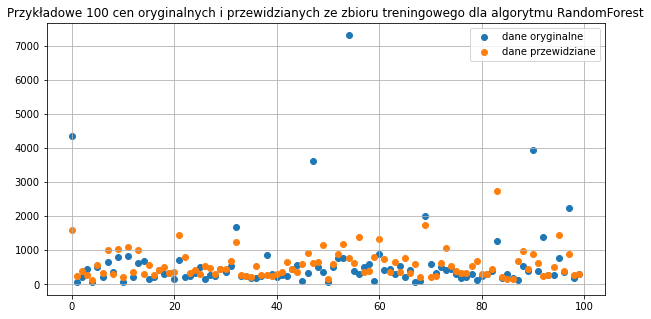

In [55]:
train_x, val_x, train_y, val_y = train_test_split(X_train, y_train, test_size = 0.33, random_state = 123)

rf = RandomForestRegressor(n_estimators=60, max_depth=30, random_state=100, n_jobs=-1)

rf.fit(train_x, train_y)

y_ = rf.predict(val_x)

y_pred = sc.inverse_transform([y_])
y_true = sc.inverse_transform([val_y])

score_ = rf.score(train_x, train_y)  
score_perc = mean_absolute_percentage_error(y_pred, y_true)
print("Training score", score_)
print("Mean absolute percentage error", score_perc)

x_ax = range(len(y_true[0][:100]))

plt.figure(figsize=(10,5))
plt.scatter(x_ax, y_true[0][:100], label="dane oryginalne")
plt.scatter(x_ax, y_pred[0][:100], label="dane przewidziane")
plt.title("Przykładowe 100 cen oryginalnych i przewidzianych ze zbioru treningowego dla algorytmu RandomForest")
plt.grid()
plt.legend()
plt.show()

In [56]:
def forest_estimators(X_train, y_train, X_test, i):

    rf = RandomForestRegressor(n_estimators=i, max_depth=30, random_state=50, n_jobs=-1)

    rf.fit(X_train, y_train)

    y_ = rf.predict(X_test)

    return rf.score(X_train, y_train)

Training score:  0.42647316294786997
Training score:  0.7353265955676571
Training score:  0.7508212753516199
Training score:  0.7561345043264008
Training score:  0.7565223870628716
Training score:  0.7580998884426275
Training score:  0.7612971675243329
Training score:  0.761002052156221
Training score:  0.7613419479588192
Training score:  0.7622968096380647
Training score:  0.7623207860108819
Training score:  0.7616772158210237
Training score:  0.7603464369542225
Training score:  0.7608214162962355
Training score:  0.7621200845872597


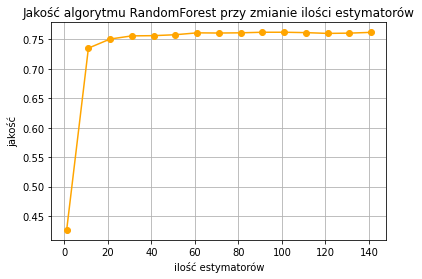

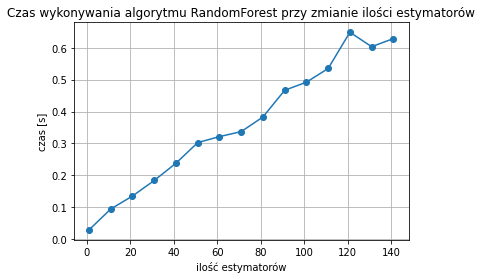

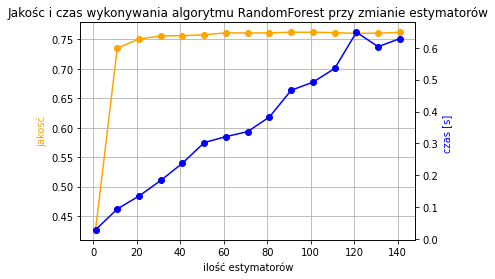

In [57]:
skorr = []
times = []
I = np.arange(1, 150, 10)
for i in I:
    start = time.time()
    score_ = forest_estimators(X_train=X_train, y_train=y_train, X_test=X_test,  i=i)
    stop = time.time()

    print("Training score: ", score_)
    skorr.append(score_)
    times.append(stop-start)

plt.figure()
plt.plot(I, skorr, '-o', color='orange')
plt.title('Jakość algorytmu RandomForest przy zmianie ilości estymatorów')
plt.grid()
plt.ylabel('jakość')
plt.xlabel('ilość estymatorów')
plt.show()

plt.figure()
plt.plot(I, times, '-o')
plt.title('Czas wykonywania algorytmu RandomForest przy zmianie ilości estymatorów')
plt.grid()
plt.ylabel('czas [s]')
plt.xlabel('ilość estymatorów')
plt.show()

fig, ax1 = plt.subplots()
ax1.plot(I, skorr, color='orange', marker='o')
ax1.grid()
ax1.set_title('Jakośc i czas wykonywania algorytmu RandomForest przy zmianie estymatorów')
ax1.set_xlabel('ilość estymatorów')
ax1.set_ylabel('jakosć', color='orange')

ax2=ax1.twinx()
ax2.plot(I, times, color='blue', marker='o')
ax2.set_ylabel("czas [s] ", color='blue')
plt.show()

In [58]:
def forest_depth(X_train, y_train, X_test, n):

    rf = RandomForestRegressor(n_estimators=60, max_depth=n, random_state=50, n_jobs=-1)

    rf.fit(X_train, y_train)

    y_ = rf.predict(X_test)

    return rf.score(X_train, y_train)

Training score:  0.05688037166347948
Training score:  0.13950712303905188
Training score:  0.2822038531655312
Training score:  0.4043705792817258
Training score:  0.5215410792493558
Training score:  0.6201851385023865
Training score:  0.6892121383469001
Training score:  0.7293763071469259
Training score:  0.7491413883804573
Training score:  0.756617027861884
Training score:  0.7592452323398755
Training score:  0.7607819714329223
Training score:  0.7610263822156494
Training score:  0.7611401864908782
Training score:  0.7610844978030928


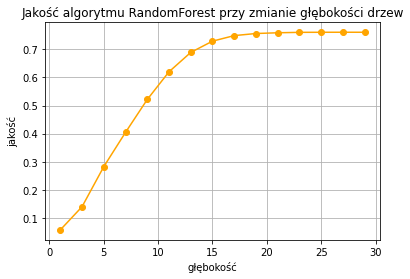

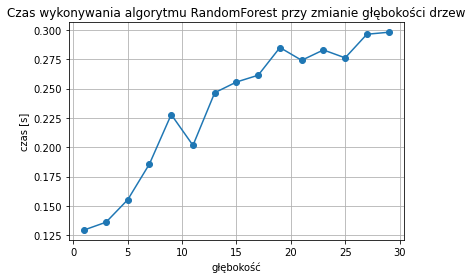

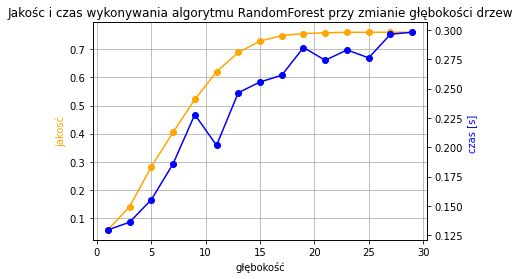

In [59]:
N = np.arange(1, 30, 2)
depth_score = []
times = []
for n in N:
    start = time.time()
    score_ = forest_depth(X_train=X_train, y_train=y_train, X_test=X_test,  n=n)
    stop = time.time()

    print("Training score: ", score_)
    depth_score.append(score_)
    times.append(stop-start)

plt.figure()
plt.plot(N, depth_score, '-o', color='orange')
plt.title('Jakość algorytmu RandomForest przy zmianie głębokości drzew')
plt.grid()
plt.ylabel('jakość')
plt.xlabel('głębokość')
plt.show()

plt.figure()
plt.plot(N, times, '-o')
plt.title('Czas wykonywania algorytmu RandomForest przy zmianie głębokości drzew')
plt.grid()
plt.ylabel('czas [s]')
plt.xlabel('głębokość')
plt.show()

fig, ax1 = plt.subplots()
ax1.plot(N, depth_score, color='orange', marker='o')
ax1.grid()
ax1.set_title('Jakośc i czas wykonywania algorytmu RandomForest przy zmianie głębokości drzew')
ax1.set_xlabel('głębokość')
ax1.set_ylabel('jakosć', color='orange')

ax2=ax1.twinx()
ax2.plot(N, times, color='blue', marker='o')
ax2.set_ylabel("czas [s] ", color='blue')
plt.show()

In [60]:
start = time.time()
rf = RandomForestRegressor(n_estimators=60, max_depth=30, random_state=50, n_jobs=-1)
rf.fit(X_train, y_train)

y_ = rf.predict(X_test)
stop = time.time()
y_pred = sc.inverse_transform([y_])

score_ = rf.score(X_train, y_train)  
print("Training score: ", score_)
print("Time:", stop-start)

# return score_
solution = pd.DataFrame(y_pred[0], columns = ['Price'])
solution.to_excel('RandomForest_output.xlsx')

Training score:  0.76119561921585
Time: 0.41262125968933105


In [61]:
solution.describe()

,Price
count,1560.000000
mean,552.702686
std,384.491632
min,126.500000
25%,337.708958
50%,441.495500
75%,640.042750
max,3930.480667
